<a href="https://colab.research.google.com/github/Kontrabass2018/DeepLearningGPU/blob/main/Tech_talk_IRIC_Omics_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import the libraries

In [ ]:
# This get the RAPIDS-Colab install files
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py latest

fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
Installing RAPIDS Stable 25.02.*
Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 150.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 74.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 120.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 79.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 851.2/851.2 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.5/293.5 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.2/160.2 kB 136.5 MB/s eta 0:00:00


In [1]:
from cuml import UMAP as UMAP_GPU

In [7]:
import os
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cuml import UMAP as UMAP_GPU
from cuml.decomposition import PCA as PCA_GPU

# Load the data

In [8]:
infilename = "TCGA_TPM_lab.h5"
colors_fname = "TCGA_colors_def.txt"
data_url = "https://bioinfo.iric.ca/~sauves/VARIA"
os.system(f"wget {data_url}/{infilename}")
os.system(f"wget {data_url}/{colors_fname}")

0

In [3]:
TCGA_data = h5py.File("TCGA_TPM_lab.h5", "r")
clrs = pd.read_csv("TCGA_colors_def.txt")

In [4]:
tpm_data = TCGA_data["data"][TCGA_data["biotypes"][:].astype(str) == "protein_coding",:].T
labels = TCGA_data["labels"][:].astype(str)


## Self-defined plotting function

In [16]:
def plot_redux(X_tr, labels, clrs):
  fig = plt.figure(dpi = 300)
  axis = fig.add_subplot(111)
  for lab in np.unique(labels):
      group = labels == lab
      col = clrs[clrs["labs"] == lab].hexcolor.values[0]
      axis.scatter(X_tr[group, 0], X_tr[group, 1],s=12, c = col,linewidths=0.5, edgecolors = "k")
  plt.tight_layout()

# Running a PCA

In [21]:
from cuml.decomposition import IncrementalPCA
ipca = IncrementalPCA(n_components=2, batch_size=200)
ipca.fit(tpm_data)
X_tr_pca = ipca.transform(tpm_data)

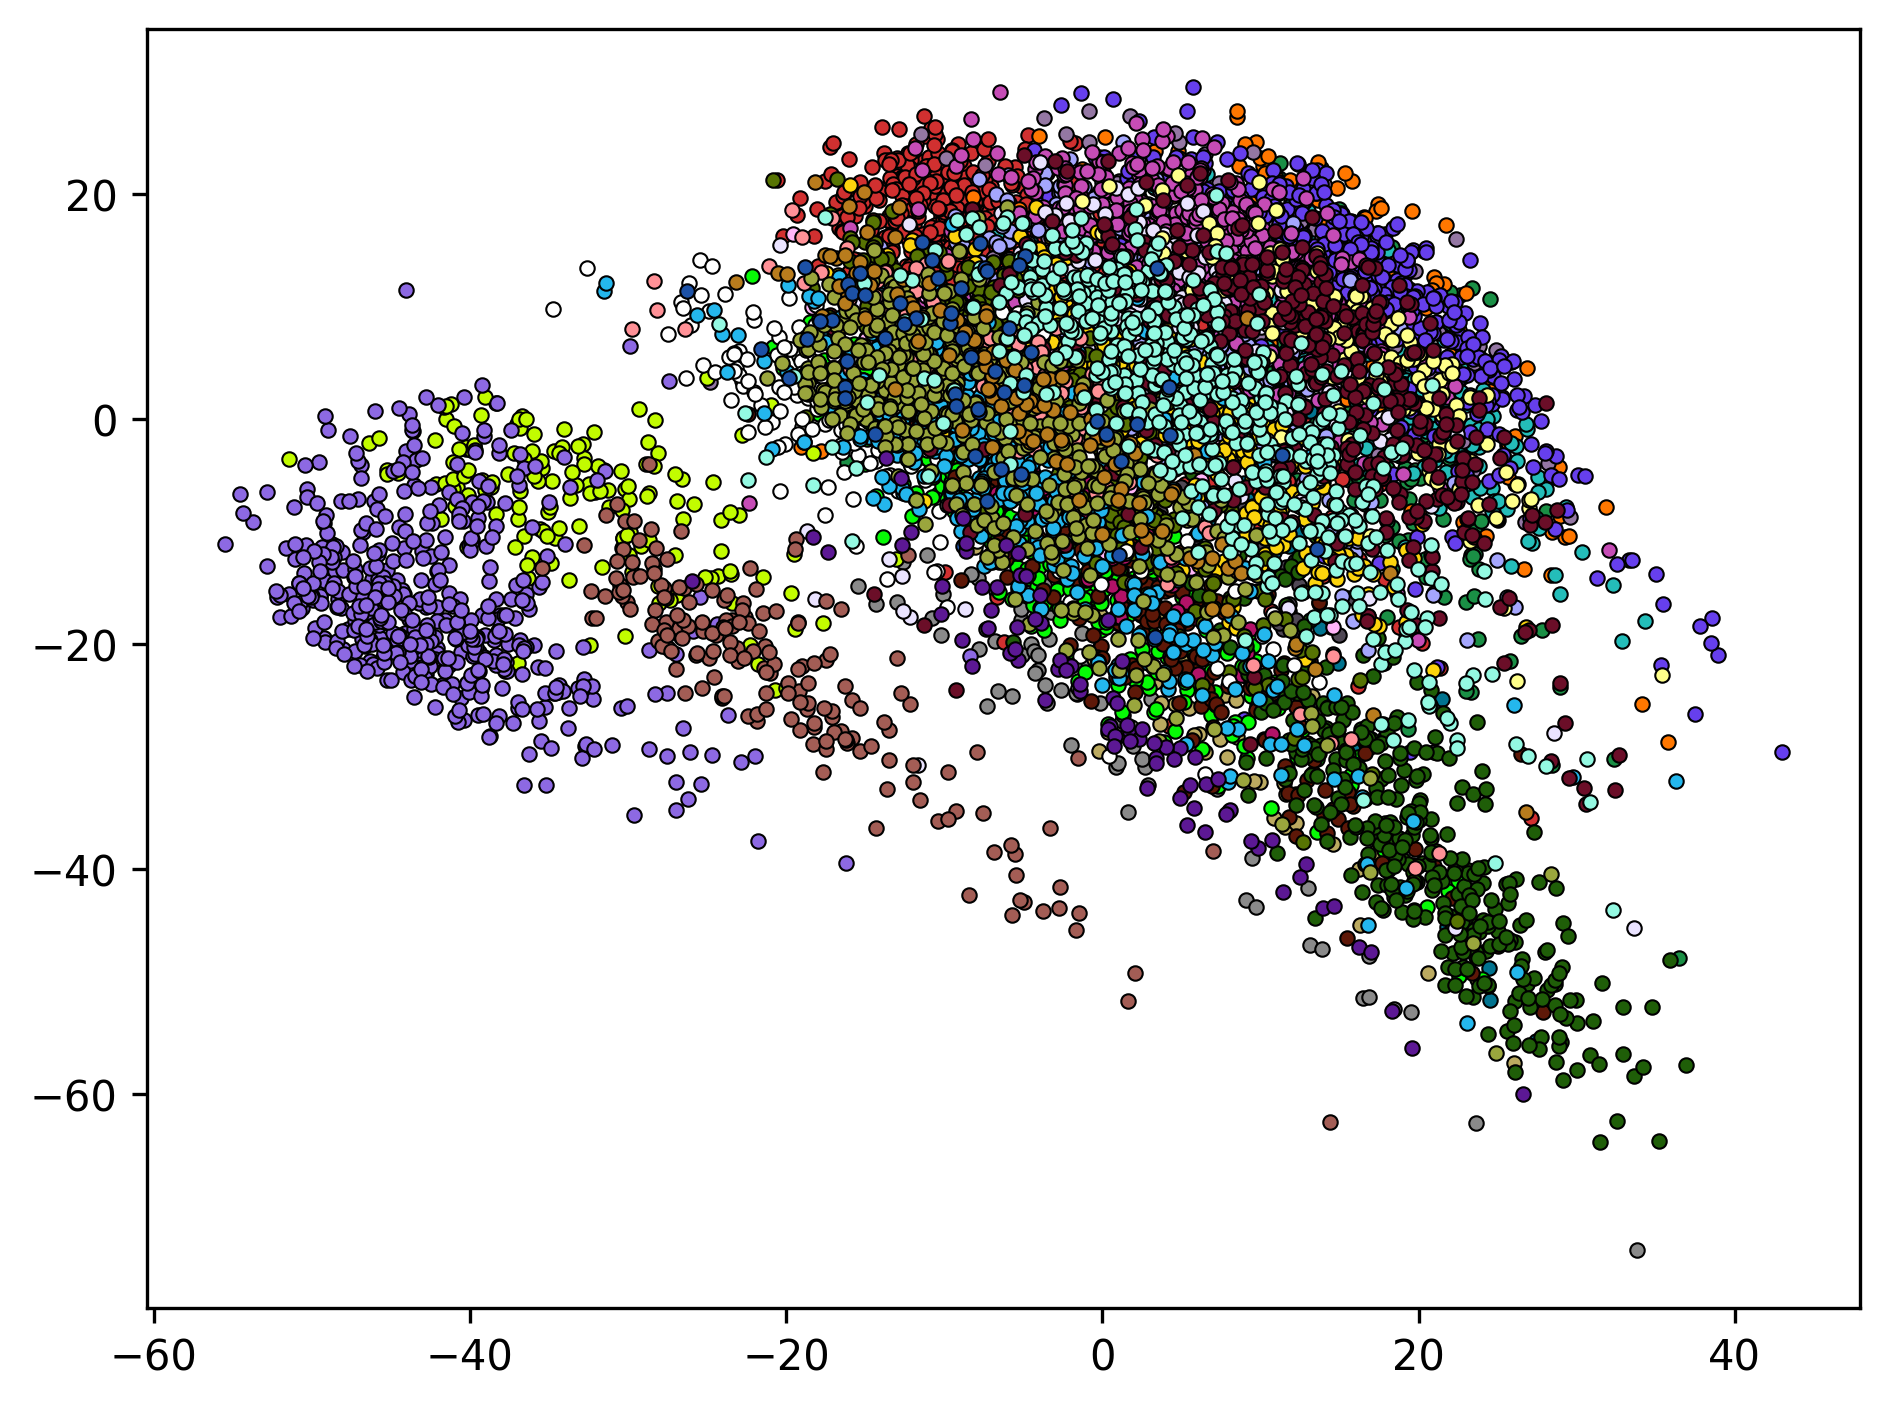

In [22]:
plot_redux(X_tr_pca, labels, clrs)
plt.savefig("PCA_plot.svg")

# Running UMAP

In [18]:
umap_gpu = UMAP_GPU(n_neighbors=30, min_dist = 0.7, n_components=2)
X_tr_umap = umap_gpu.fit_transform(tpm_data)


[2025-02-25 17:57:18.586] [CUML] [info] Building knn graph using brute force


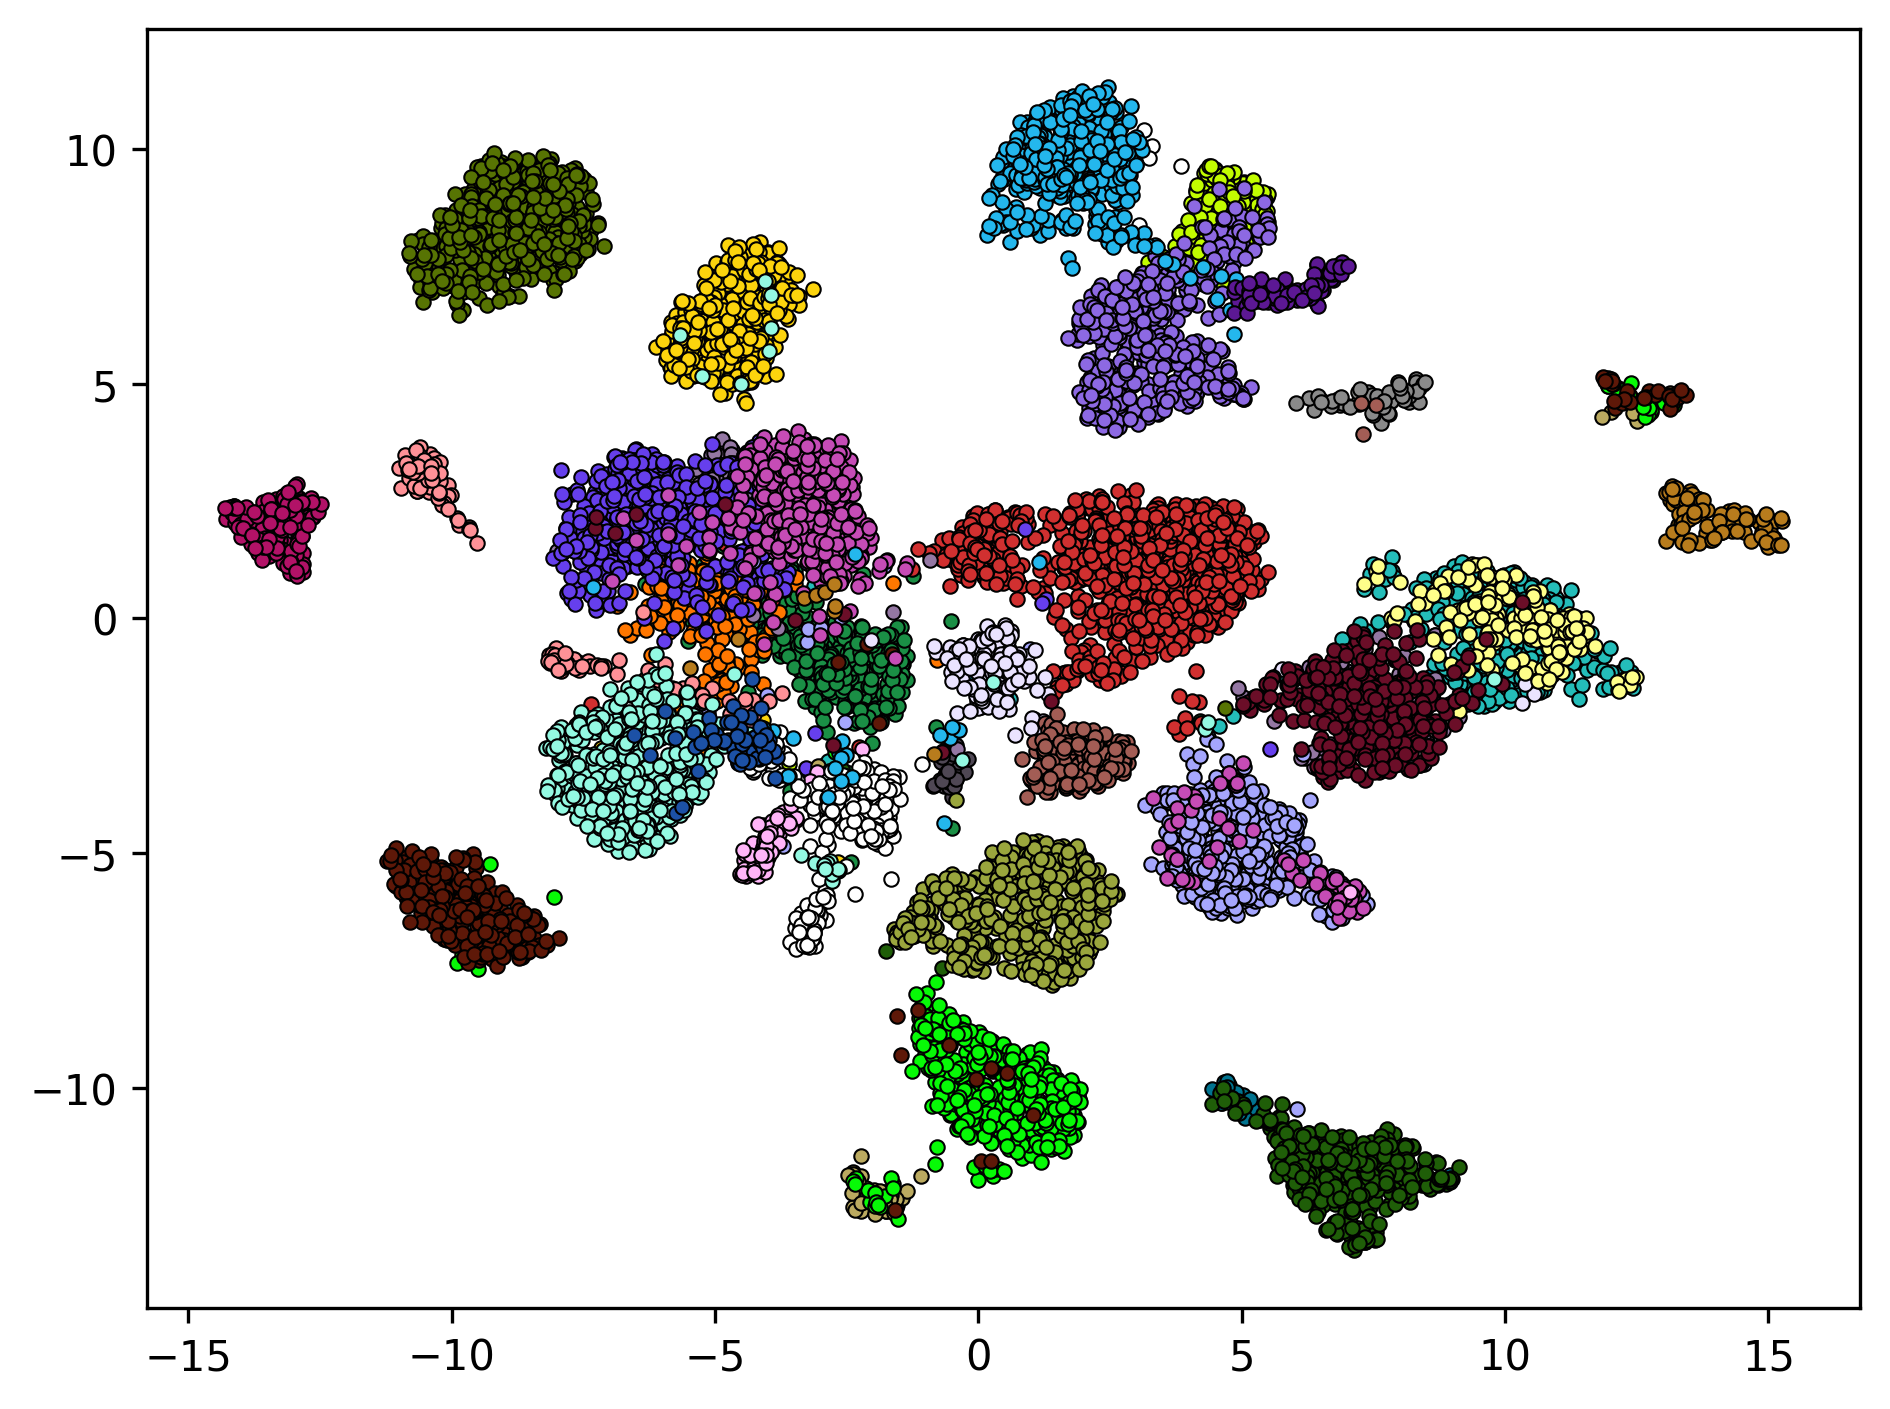

In [19]:
plot_redux(X_tr_umap, labels, clrs)